# KPI 1: Utilisation rate

* monthly
* daily
* hourly

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns




from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




## Data Readin:

In [4]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    return trip_data



### Data Plotting def:

In [5]:
def get_timeperiod(mode):
    return mode["day"].nunique()
    
    



def set_utilization(df, timereolution):
    timeperiod = get_timeperiod(df)
    bike_usage = df.groupby([timereolution], as_index= True )["b_number"].count().reset_index()
    bike_fleet = df["b_number"].nunique()
    bike_usage['utilization']=bike_usage['b_number'].apply(lambda x: x / bike_fleet)    
    return bike_usage




    


def general_utilization(city_name,lable,provider,dataset):
    mode = read_data(city_name)



    # differnt temporal_resolutions
    df_hour = set_utilization (mode, "hour")
    df_weekday = set_utilization (mode, "weekday")
    df_month = set_utilization (mode, "month")
    
    # plots
    fig1, (ax1) = plt.subplots(1, 1, figsize=(15,5))
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(15,5))

    sns.barplot(x="hour", y="utilization", data=df_hour, palette="rocket", ax=ax1)
    sns.barplot(x="weekday", y="utilization", data=df_weekday, palette="rocket", ax=ax2)
    sns.barplot(x="month", y="utilization", data=df_month, palette="rocket", ax=ax3) 
    
    # add mean utilization line to plot
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
    ax1.axhline(y = df_hour['utilization'].mean(), color='red', linewidth=2, alpha=.7)
    ax1.set(xlabel='Hours', ylabel="Average "+lable+" utilization")
    ax1.set_title(provider+": Average "+lable+" utilization per hour")

    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
    ax2.axhline(y = df_weekday['utilization'].mean(), color='red', linewidth=2, alpha=.7)
    ax2.set(xlabel='Weekdays', ylabel="Average "+lable+" utilization")
    ax2.set_title(provider+": Average "+lable+" utilization per weekday")

    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")
    ax3.axhline(y = df_month['utilization'].mean(), color='red', linewidth=2, alpha=.7)
    ax3.set(xlabel='Month', ylabel="Average "+lable+" utilization")
    ax3.set_title(provider+": Average "+lable+" utilization per month" ) 
    
    
#    fig1.savefig("Test_Pictures/general_utilization_hour_"+provider+"_"+lable+"_"+dataset+".pdf")
#    fig2.savefig("Test_Pictures/general_utilization_month&weekday_"+provider+"_"+lable+"_"+dataset+".pdf")

    fig1.tight_layout()
    fig2.tight_layout()
    return 

## Regression def:

In [6]:
def weather_utilization (data):
    plot_weather_daily_average(data, "wind")
    plot_weather_daily_average(data, "rain")
    plot_weather_daily_average(data, "temp")
    plot_weather_hourly(data, "wind")
    plot_weather_hourly(data, "rain")
    plot_weather_hourly(data, "temp")
    
def plot_weather_hourly (data,condition):
    weather_hourly = pd.DataFrame()
    weather_hourly[condition] = data.groupby("rounded_time_hourly")[condition].mean()
    weather_hourly["number_ids"]= data.groupby("rounded_time_hourly")["b_number"].count()
    xp = weather_hourly[condition].values.reshape((-1,1)) 
    yp = weather_hourly["number_ids"]
    fig, ax = plt.subplots(figsize = (8,6))
    # Plotting the data
    ax.scatter(xp, yp, marker='x',)
    ax.set_xlabel("Hourly " + condition)
    ax.set_ylabel("Demand ")
    plt.show()    
    
def plot_weather_daily_average (data,condition):
    xp = data.groupby("day")[condition].mean()
    yp = data.groupby("day")["b_number"].count()
    fig, ax = plt.subplots(figsize = (8,6))
    # Plotting the data
    ax.scatter(xp, yp, marker='x',)
    ax.set_xlabel("Average daily " + condition)
    ax.set_ylabel("Demand ")
    plt.show()



In [7]:
def weather_utilization_regression (data):
    plot_weather_daily_average_regression(data, "wind")
    plot_weather_daily_average_regression(data, "rain")
    plot_weather_daily_average_regression(data, "temp")
    plot_weather_hourly_regression(data, "wind")
    plot_weather_hourly_regression(data, "rain")
    plot_weather_hourly_regression(data, "temp")
    
def plot_weather_hourly_regression (data,condition):
    weather_hourly = pd.DataFrame()
    weather_hourly[condition] = data.groupby("rounded_time_hourly")[condition].mean()
    weather_hourly["number_ids"]= data.groupby("rounded_time_hourly")["b_number"].count()
    X = weather_hourly[condition].values.reshape((-1,1)) 
    y = weather_hourly["number_ids"]
    # initialize model
    lin_mod = LinearRegression()

#train model
    lin_mod.fit(X, y)

#make predictions using model
    model_pred = lin_mod.predict(X)

# plot results
    plt.figure(figsize = (8,6))
    plt.scatter(X, y, marker="x")
    plt.xlabel(condition+" hourly")
    plt.ylabel("Demand hourly")
    plt.plot(X, model_pred, c='C2')
    plt.legend(['Squared loss fit','Observed days'])
    print(lin_mod.coef_, lin_mod.intercept_)

def plot_weather_daily_average_regression (data,condition):
    weather_hourly = pd.DataFrame()
    weather_hourly[condition] = data.groupby("day")[condition].mean()
    weather_hourly["number_ids"]= data.groupby("day")["b_number"].count()
    X = weather_hourly[condition].values.reshape((-1,1)) 
    y = weather_hourly["number_ids"]
       # initialize model
    lin_mod = LinearRegression()

#train model
    lin_mod.fit(X, y)

#make predictions using model
    model_pred = lin_mod.predict(X)

# plot results
    plt.figure(figsize = (8,6))
    plt.scatter(X, y, marker="x")
    plt.xlabel("mean daily "+condition)
    plt.ylabel("average daily deamand")
    plt.plot(X, model_pred, c='C2')
    plt.legend(['Squared loss fit','Observed days'])
    print(lin_mod.coef_, lin_mod.intercept_)

# Utilization rate plots Duesseldorf:

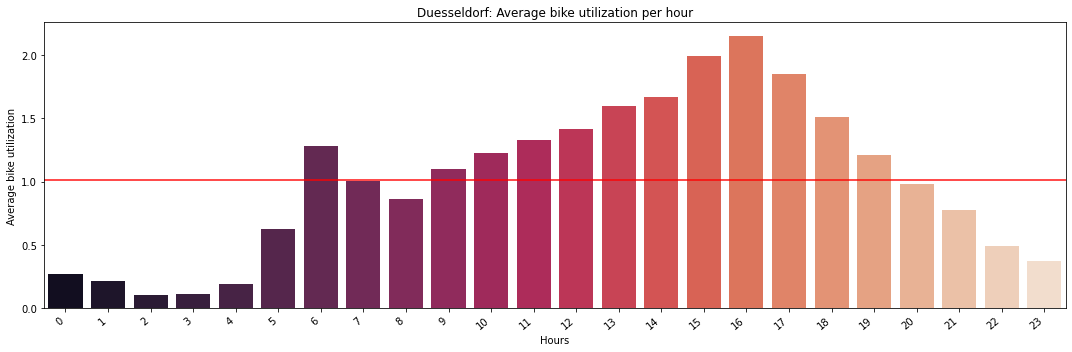

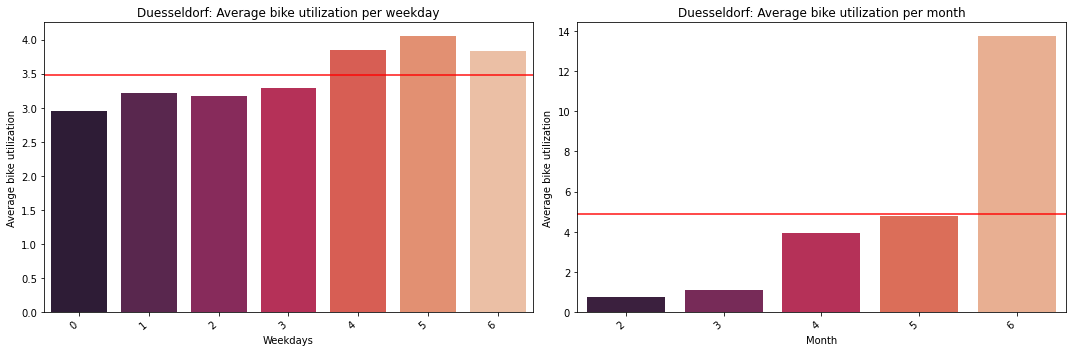

In [8]:
general_utilization("duesseldorf","bike","Duesseldorf","dataset")


[-14.34234539] 186.4932878955555
[-168.73356474] 129.1854989058963
[16.74623706] -105.02106289844583
[0.04106496] 7.2342866843144344
[-1.15958725] 7.45660479120085
[0.85746395] -4.574634195945075


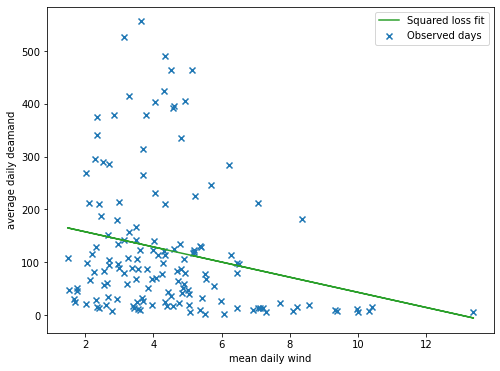

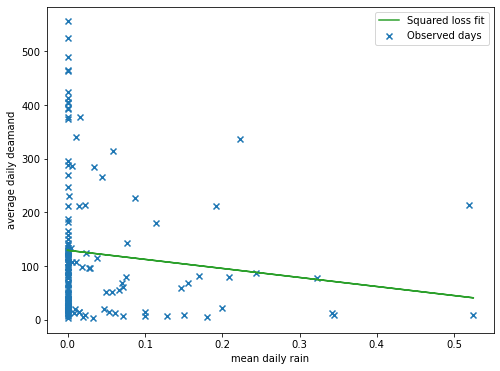

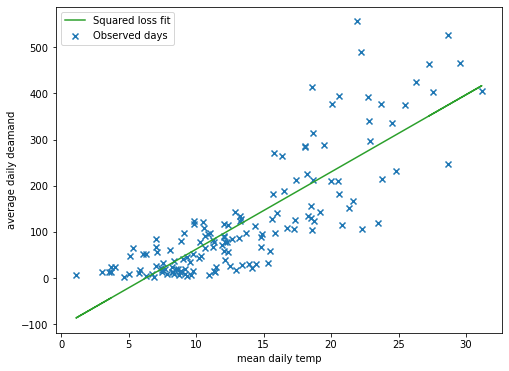

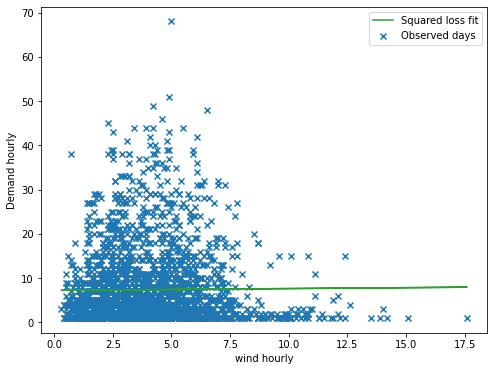

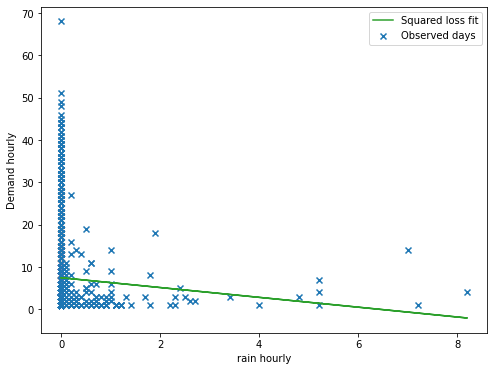

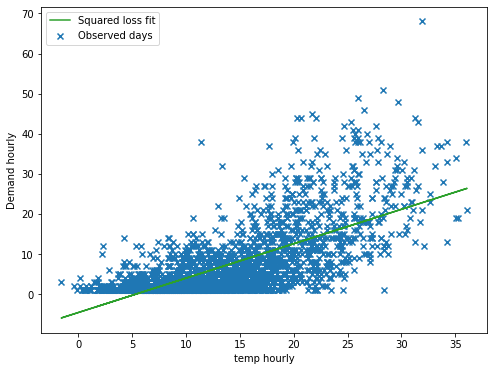

In [9]:
weather_utilization_regression(read_data("duesseldorf"))

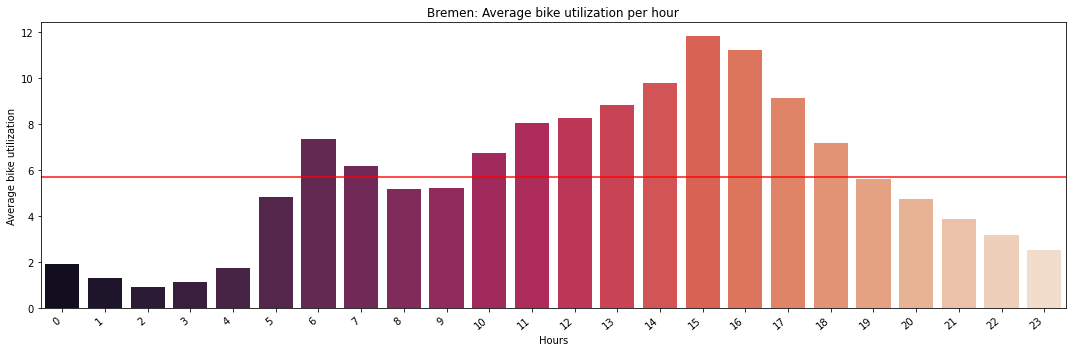

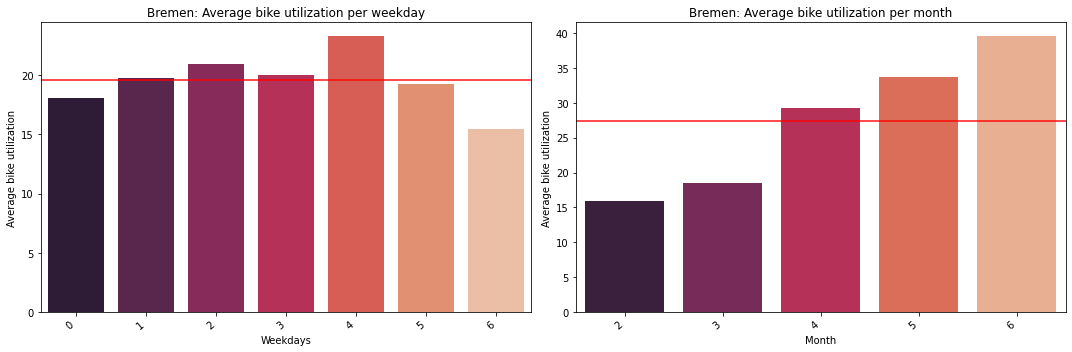

In [10]:
general_utilization("bremen","bike","Bremen","dataset")

[-20.68187295] 492.2698325945259
[-381.20240355] 409.43058741517575
[18.26121126] 168.49777701415155
[0.64963572] 14.38742365485859
[-3.23700736] 17.403323099404698
[1.1157898] 4.760487299524616


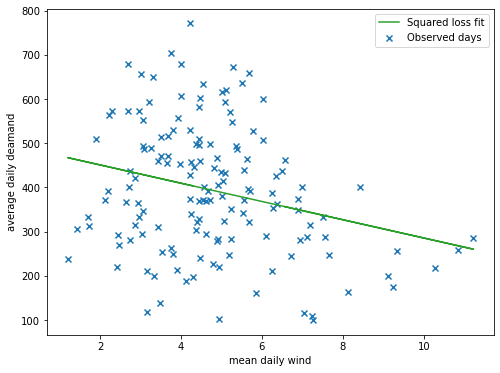

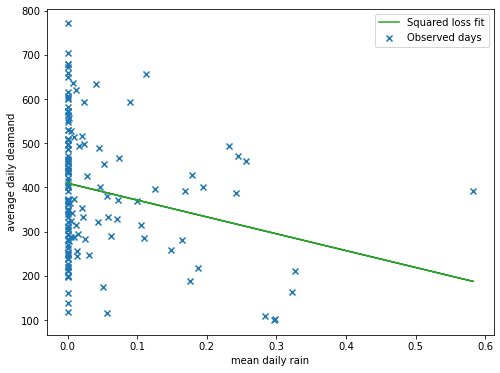

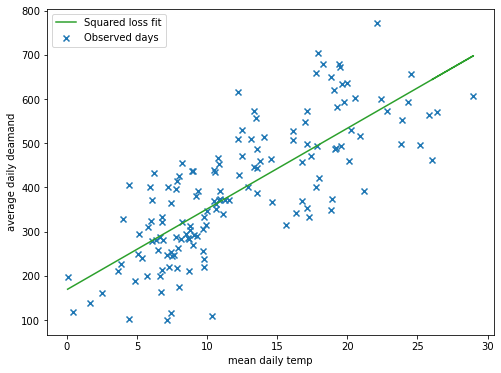

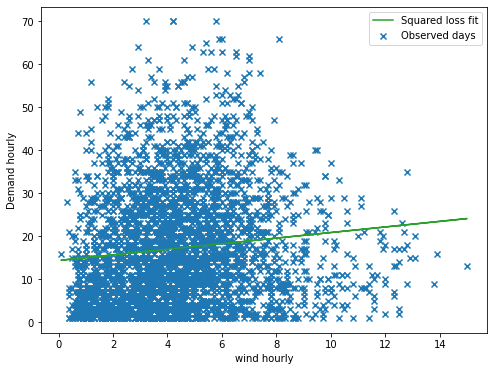

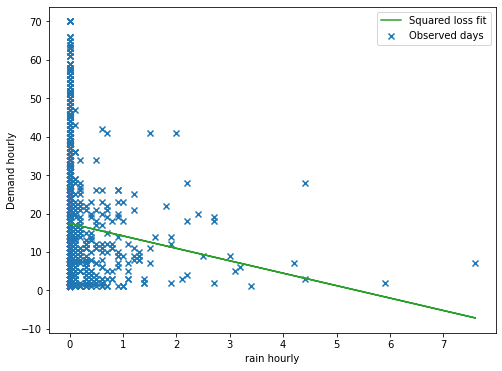

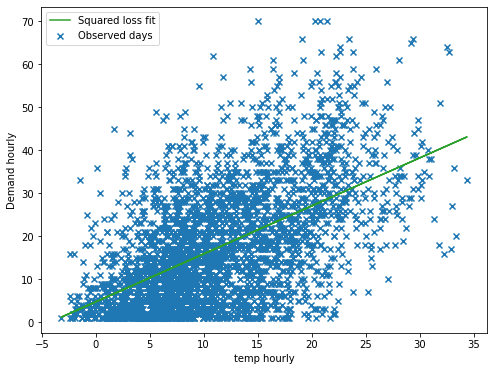

In [11]:
weather_utilization_regression(read_data("bremen"))